# Rotor Average Models

The rotor average model in PyWake defines one or more points at the turbine rotor to calculate a (weighted) rotor-average deficit. It includes:

- [RotorCenter](#RotorCenter): One point at the center of the rotor
- [GridRotorAvg](#GridRotorAvg): Custom grid in Cartesian coordinates'
- [EqGridRotorAvg](#EqGridRotorAvg): Equidistant N x N Cartesian grid covering the rotor
- [GQGridRotorAvg](#GQGridRotorAvg): M x N cartesian grid using Gaussian quadrature coordinates and weights
- [PolarGridRotorAvg](#PolarGridRotorAvg): Custom grid in polar coordinates  
- [CGIRotorAVG](#CGIRotorAvg): Circular Gauss Integration

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import and setup site and windTurbines
import py_wake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

In the plots below, it is clearly seen that the wind speed varies over the rotor, and that the the rotor-average wind speed is not well-defined by the wind sped at the rotor center.

Text(0, 0.5, 'Wind speed [m/s]')

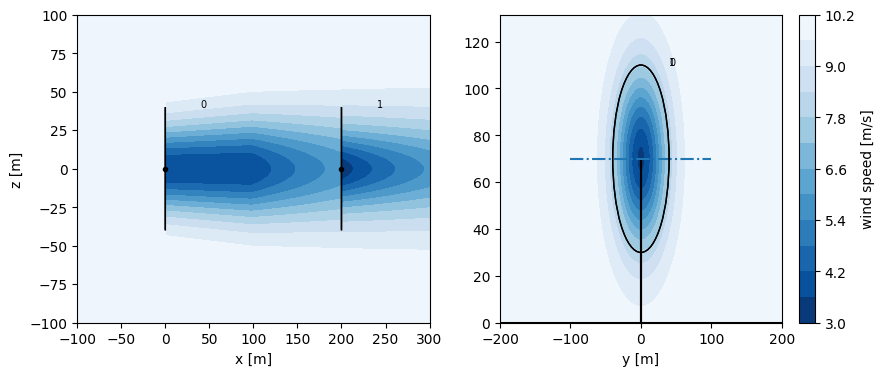

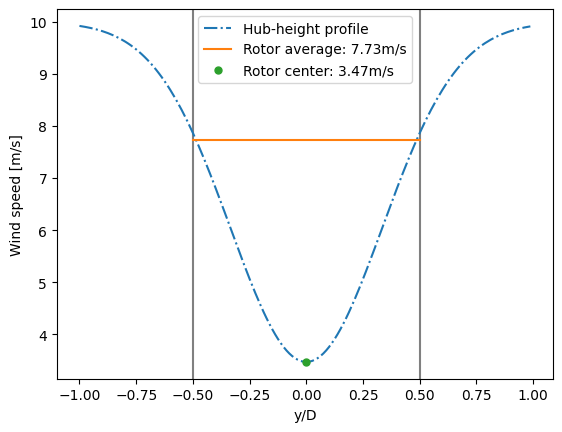

In [6]:
from py_wake.superposition_models import SquaredSum
from py_wake.flow_map import HorizontalGrid, YZGrid
from py_wake import BastankhahGaussian

D = 80
R = D/2
wfm = BastankhahGaussian(site, windTurbines, superpositionModel=SquaredSum())
sim_res = wfm([0,200],[0,0],wd=270,ws=10)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_xlabel("x [m]"), ax1.set_ylabel("y [m]")
sim_res.flow_map(HorizontalGrid(extend=.1)).plot_wake_map(10, ax=ax1, plot_colorbar=False)
sim_res.flow_map(YZGrid(x=199.99)).plot_wake_map(10, ax=ax2)
ax2.plot([-100,100],[70,70],'-.')
ax2.set_xlabel("y [m]"), ax1.set_ylabel("z [m]")

plt.figure()
flow_map = sim_res.flow_map(HorizontalGrid(x=[199.99], y=np.arange(-80, 80)))

for x in [-.5,.5]:
    plt.gca().axvline(x,color='grey')
plt.plot(flow_map.Y[:, 0]/D, flow_map.WS_eff_xylk[:, 0, 0, 0], '-.', label='Hub-height profile')
plt.plot([-.5,.5],[7.73,7.73],label='Rotor average: 7.73m/s')
rc_ws = flow_map.WS_eff_xylk[80, 0, 0, 0]
plt.plot(flow_map.Y[80, 0]/D, rc_ws,'.', ms=10, label='Rotor center: %.2fm/s'%rc_ws)
plt.legend()
plt.xlabel("y/D")
plt.ylabel('Wind speed [m/s]')

First we create a simple function to model all of the rotor-average models available in PyWake.

In [7]:
from py_wake.rotor_avg_models import RotorCenter, GridRotorAvg, EqGridRotorAvg, GQGridRotorAvg, CGIRotorAvg, PolarGridRotorAvg, PolarRotorAvg, polar_gauss_quadrature, GaussianOverlapAvgModel
from py_wake.flow_map import HorizontalGrid

R=D/2

def plot_rotor_avg_model(rotorAvgModel, name):
    plt.figure()
    m = rotorAvgModel
    wfm = BastankhahGaussian(site,windTurbines,rotorAvgModel=m)
    ws_eff = wfm([0, 200], [0, 0], wd=270, ws=10).WS_eff_ilk[1,0,0]
    plt.title(name)
    c = plt.scatter(m.nodes_x, m.nodes_y,c=m.nodes_weight,label="%.2fm/s"%(ws_eff))
    plt.colorbar(c,label='weight')
    plt.gca().add_artist(plt.Circle((0,0),1,fill=False))
    plt.axis('equal')
    plt.xlabel("y/R"); plt.ylabel('z/R')
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.legend()

### RotorCenter
Setting `rotorAvgModel=None` determines the rotor average wind speed from the rotor center point. Alternatively, you can use the `RotorCenter` model which is equivalent.

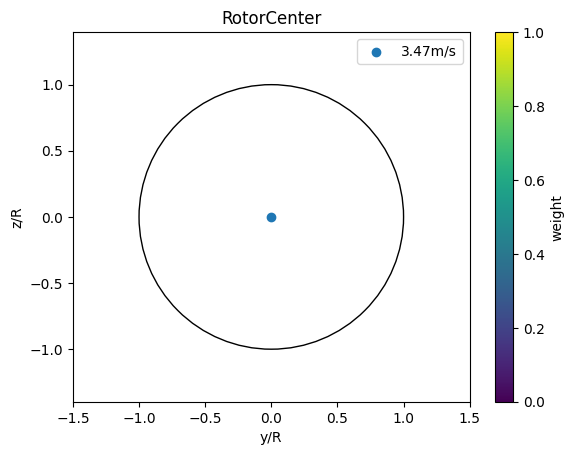

In [8]:
plot_rotor_avg_model(RotorCenter(), 'RotorCenter')

### GridRotorAvg

The `GridRotorAvg` defines a set of points in cartesian coordinates.

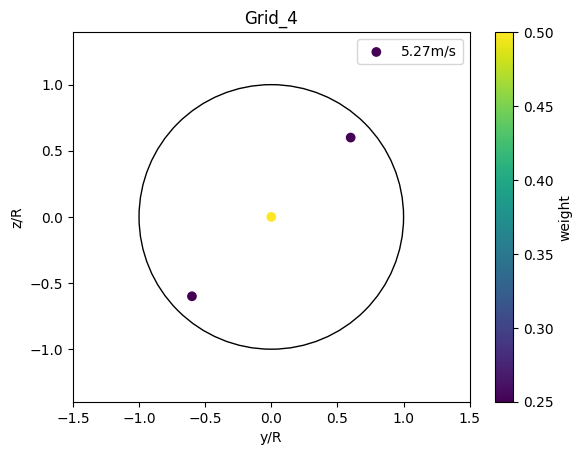

In [9]:
x = y = np.array([-.6, 0,.6])
plot_rotor_avg_model(GridRotorAvg(x,y,nodes_weight = [0.25,.5,.25]), 'Grid_4')

### EqGridRotorAvg

The `EqGridRotorAvg` defines a NxN equidistant cartesian grid of points and discards points outside the rotor.

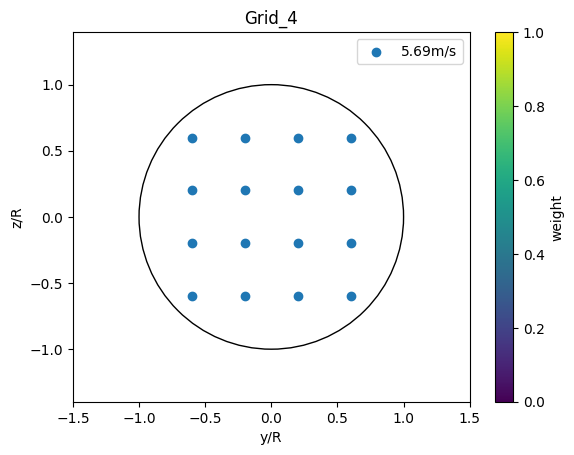

In [10]:
plot_rotor_avg_model(EqGridRotorAvg(4), 'Grid_4')

### GQGridRotorAvg

The `GQGridRotorAvg` defines a grid of M x N cartesian grid points using Gaussian quadrature coordinates and weights.

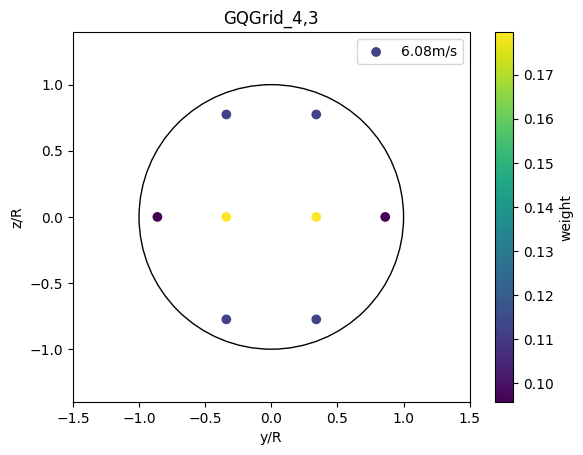

In [11]:
plot_rotor_avg_model(GQGridRotorAvg(4,3), 'GQGrid_4,3')

### PolarGridRotorAvg

The `PolarGridRotorAvg` defines a grid in polar coordinates.

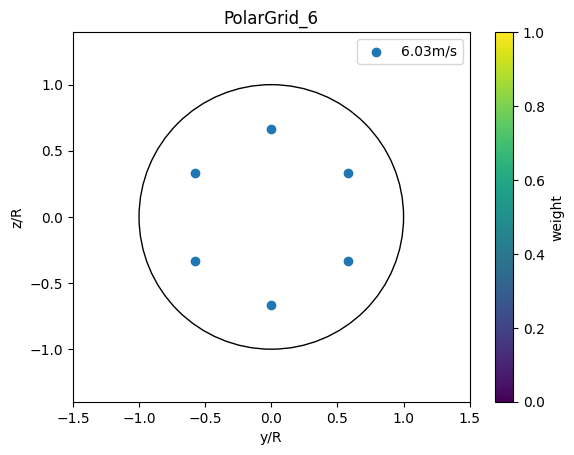

In [13]:
theta = np.linspace(-np.pi,np.pi,6, endpoint=False)
r = 2/3
plot_rotor_avg_model(PolarGridRotorAvg(r=r, theta=theta, r_weight=None, theta_weight=None), 'PolarGrid_6')

**The polar grid can be combined with Gaussian Quadrature.** 

This is similar to the implementation in FusedWake: https://gitlab.windenergy.dtu.dk/TOPFARM/FUSED-Wake/-/blob/master/fusedwake/gcl/fortran/GCL.f

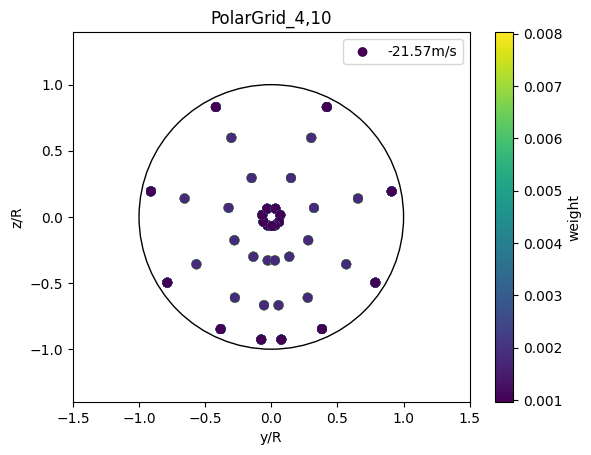

In [14]:
plot_rotor_avg_model(PolarGridRotorAvg(*polar_gauss_quadrature(4,10)), 'PolarGrid_4,10')

### CGIRotorAvg
Circular Gauss integration with 4,7,9 or 21 points as defined in Abramowitz M and Stegun A. Handbook of Mathematical Functions. Dover: New York, 1970.

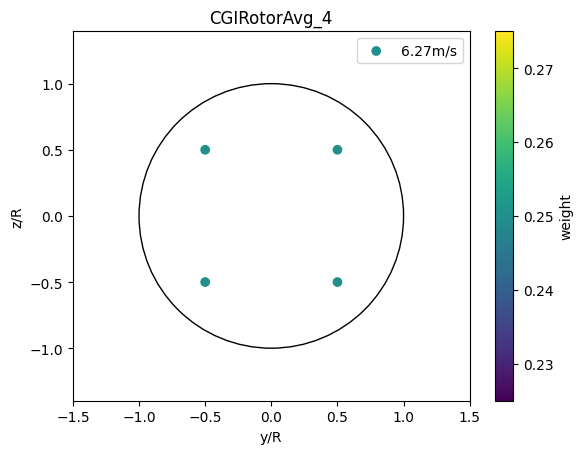

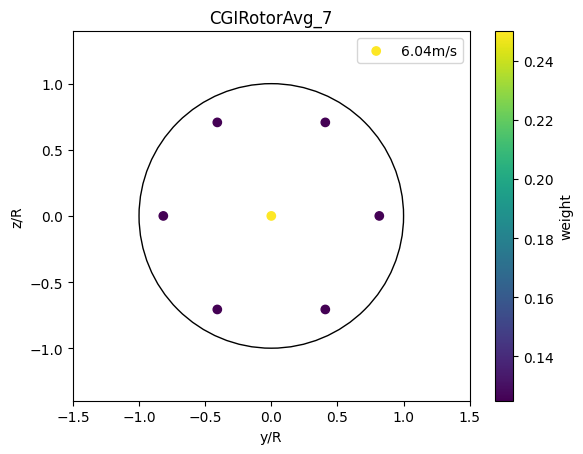

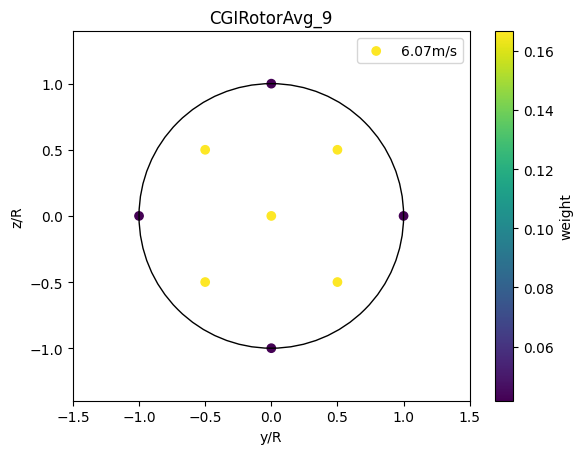

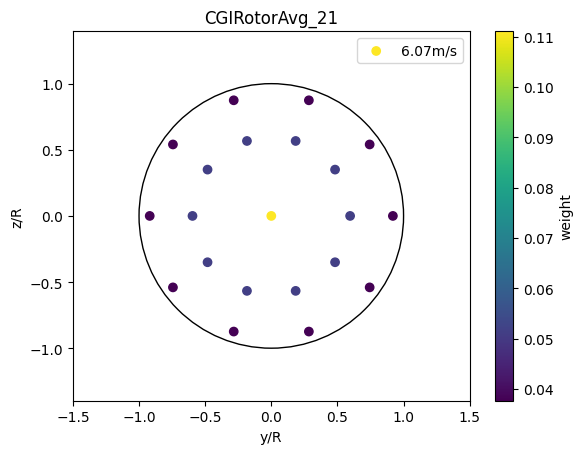

In [15]:
for n in [4,7,9,21]:
    plot_rotor_avg_model(CGIRotorAvg(n), 'CGIRotorAvg_%d'%n)

### AreaOverlapModel
The AreaOverlapModel calculates the fraction of the downstream rotor that is covered by the wake from an upstream wind turbine. This model makes sense for tophat wake deficit models only, e.g. NOJDeficit.


The calculation formula can be found in Eq. (A1) of  Feng, J., & Shen, W. Z. (2015). Solving the wind farm layout optimization problem using random search algorithm. Renewable Energy, 78, 182-192. https://doi.org/10.1016/j.renene.2015.01.005

<center><img src="images/AreaOverlap.svg" height="100"/></center>

### GaussianOverlapAvgModel

The GaussianOverlapModel computes the integral of the gaussian wake deficit over the downstream rotor. To speed up the computation, normalized integrals have been precalculated and stored in a look-up table. This model need the gaussian width parameter, $\sigma$, and therefore only applies to gaussian wake deficit models. 
See Appendix A in https://github.com/OrstedRD/TurbOPark/blob/main/TurbOPark%20description.pdf

<center><img src="images/GaussianOverlap.svg" height="100"/></center>

### Comparing rotor-average models
In general, the compuational cost and the accuracy of the estimate increases with the number of points, but the distribution of the points also has an impact.

The plot below shows the absolute error of the estimated rotor-average wind speed for the wind directions 
270 $\pm$ 30$^\circ$ (i.e. wind directions with more than 1% deficit) for a number of different rotor-average models.

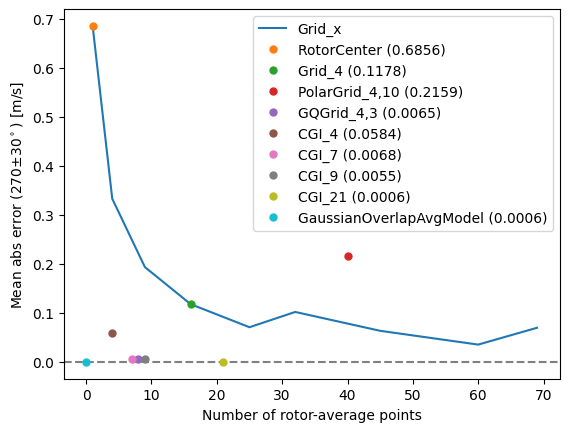

In [16]:
grid_models = [EqGridRotorAvg(i) for i in range(1,10)]
wd_lst = np.arange(240,301)

def get_ws_eff(rotorAvgModel):
    wfm = BastankhahGaussian(site,windTurbines,rotorAvgModel=rotorAvgModel)
    return wfm([0, 200], [0, 0], wd=wd_lst, ws=10).WS_eff_ilk[1,:,0]

ws_ref = get_ws_eff(EqGridRotorAvg(200)) # Use 200x200 points (31700 inside the rotor) to determine the reference value

def get_n_err(rotorAvgModel):
    ws_mean_err = np.abs(get_ws_eff(rotorAvgModel) - ws_ref).mean()
    return len(rotorAvgModel.nodes_x), ws_mean_err


plt.gca().axhline(0, color='grey',ls='--')
plt.plot(*zip(*[get_n_err(m) for m in grid_models]), label='Grid_x')
model_lst = [('RotorCenter', EqGridRotorAvg(1)),
             ('Grid_4', EqGridRotorAvg(4)),
             ('PolarGrid_4,10', PolarRotorAvg(*polar_gauss_quadrature(4,10))),
             ('GQGrid_4,3', GQGridRotorAvg(4, 3))] + \
            [('CGI_%d'%n, CGIRotorAvg(n)) for n in [4,7,9,21]]
for name, model in model_lst:
    n,err = get_n_err(model)
    plt.plot(n,err,'.',ms=10, label="%s (%.4f)"%(name,err))
goam_err = np.abs(get_ws_eff(GaussianOverlapAvgModel()) - ws_ref).mean()
plt.plot([0],[goam_err],'.', ms=10, label="GaussianOverlapAvgModel (%.4f)"%(goam_err))
plt.xlabel('Number of rotor-average points')
plt.ylabel(r'Mean abs error (270$\pm30^\circ$) [m/s]')
plt.legend()